In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,ShuffleSplit

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
def GradientBooster(param_grid, n_jobs, X_train, y_train):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=0)
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print('best estimator found by grid search: {}'.format(classifier.best_estimator_))
    return cv, classifier.best_estimator_


In [5]:
merged_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets/merged_df.pkl')
merged_df.head()

,file_idx,sequence,charge,run_mz,run_scan,run_rt,theoretical_mz,experiment_scan,experiment_rt,experiment_intensity,delta_mz,delta_scan,delta_rt
0,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608424,74.065131,601.582008,1184.1049,73.911301,602.012681,108754.444444,-0.503524,-0.153831,0.430673
1,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532311,156.625361,486.692475,1016.0286,160.291329,489.973155,58456.622222,-0.503711,3.665967,3.280680
2,0,AAAAAWEEPSSGNGTAR,2,823.382064,535.310000,367.240000,822.8783,533.861853,371.271659,277023.690476,-0.503764,-1.448147,4.031659
3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,892.112987,468.100000,997.180000,891.7775,465.668232,997.391366,150202.950000,-0.335487,-2.431768,0.211366
4,0,AAAEDVNVTFEDQQK,2,832.891998,485.630000,471.790000,832.3878,487.082550,475.841292,116982.693430,-0.504198,1.452550,4.051292


In [6]:
file_idx = 0

m/z delta estimation model (version 1)

In [7]:
# for the m/z estimation model
X = merged_df[merged_df.file_idx == file_idx][['delta_scan','delta_rt','experiment_intensity']].values
y = merged_df[merged_df.file_idx == file_idx]['delta_mz'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12467, 3) (1386, 3) (12467,) (1386,)


In [10]:
# search for the best model in the specified hyperparameter space
param_grid = {'n_estimators':[100], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth':[20, 10, 6, 4], 'min_samples_leaf':[3, 5, 9, 17], 'max_features':[1.0, 0.3, 0.1] }
n_jobs = 4
cv, best_estimator = GradientBooster(param_grid, n_jobs, X_train, y_train)

best estimator found by grid search: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=0.3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=17, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [11]:
# use the best parameters to train the model
best_estimator.fit(X_train, y_train)
print("R-squared for training set (best model found): {}".format(best_estimator.score(X_train, y_train)))

R-squared for training set (best model found): 0.08601955743242184


In [12]:
# use the trained model to predict the m/z for the test set
y_test_predicted = best_estimator.predict(X_test)

In [13]:
y_test_predicted

array([-0.44056566, -0.48105342, -0.44899078, ..., -0.45477799,
       -0.45360962, -0.45612562])

In [14]:
y_test

array([-0.50362004, -0.50305158, -0.33569327, ..., -0.50384923,
       -0.50593055, -0.50326188])

In [19]:
y_test_delta = np.abs(y_test_predicted) - np.abs(y_test)

In [20]:
np.std(y_test_delta)

0.07553819343309269

In [21]:
abs(y_test_delta).max()

0.6079263076188604

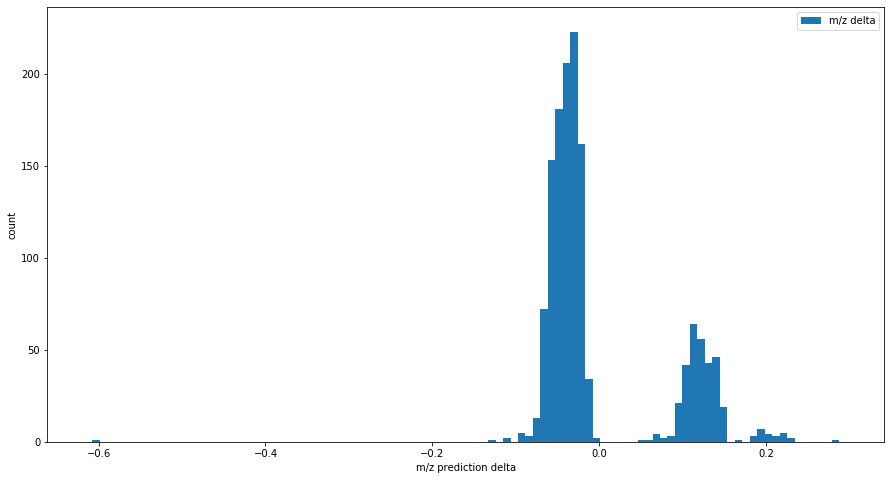

In [22]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(y_test_delta, bins=bins, label='m/z delta')
plt.legend(loc='best')
plt.xlabel('m/z prediction delta')
plt.ylabel('count')

plt.show()

m/z delta estimation model (version 2)

In [25]:
merged_df.columns

Index(['file_idx', 'sequence', 'charge', 'run_mz', 'run_scan', 'run_rt',
       'theoretical_mz', 'experiment_scan', 'experiment_rt',
       'experiment_intensity', 'delta_mz', 'delta_scan', 'delta_rt'],
      dtype='object')

In [39]:
X = merged_df[merged_df.file_idx == file_idx][['theoretical_mz','experiment_rt','experiment_scan','experiment_intensity']].values
y = merged_df[merged_df.file_idx == file_idx]['delta_mz'].values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [29]:
# search for the best model in the specified hyperparameter space
param_grid = {'n_estimators':[100], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth':[20, 10, 6, 4], 'min_samples_leaf':[3, 5, 9, 17], 'max_features':[1.0, 0.3, 0.1] }
n_jobs = 4
cv, best_estimator = GradientBooster(param_grid, n_jobs, X_train, y_train)

best estimator found by grid search: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=6,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=9, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [30]:
# use the best parameters to train the model
best_estimator.fit(X_train, y_train)
print("R-squared for training set (best model found): {}".format(best_estimator.score(X_train, y_train)))

R-squared for training set (best model found): 0.7068309054702515


In [31]:
# use the trained model to predict the m/z for the test set
y_test_predicted = best_estimator.predict(X_test)

In [32]:
y_test_predicted

array([-0.48852987, -0.48279126, -0.42263945, ..., -0.50211402,
       -0.44083512, -0.33275776])

In [33]:
y_test

array([-0.50358767, -0.50375724, -0.50313555, ..., -0.50399915,
       -0.50387281, -0.33574973])

In [34]:
y_test_delta = np.abs(y_test_predicted) - np.abs(y_test)

In [35]:
np.std(y_test_delta)

0.048614996041954295

In [36]:
abs(y_test_delta).max()

0.522391406132822

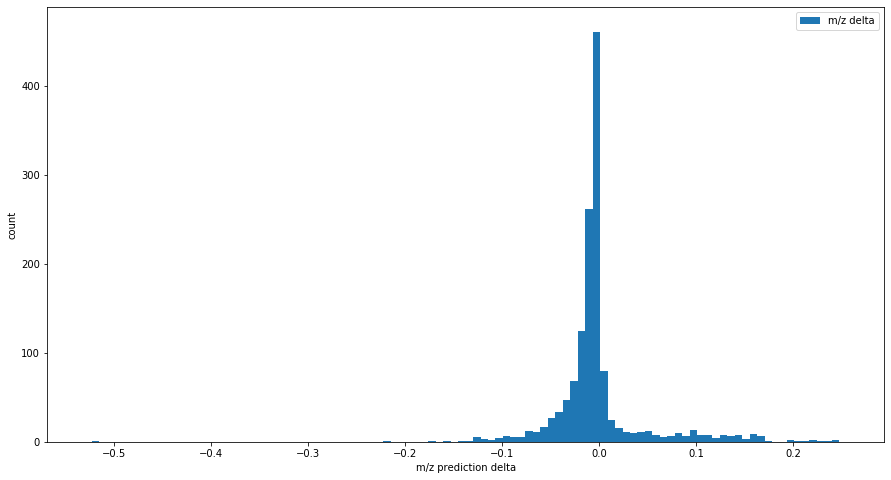

In [37]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(y_test_delta, bins=bins, label='m/z delta')
plt.legend(loc='best')
plt.xlabel('m/z prediction delta')
plt.ylabel('count')

plt.show()

scan estimation model (version 1)

In [38]:
merged_df.columns

Index(['file_idx', 'sequence', 'charge', 'run_mz', 'run_scan', 'run_rt',
       'theoretical_mz', 'experiment_scan', 'experiment_rt',
       'experiment_intensity', 'delta_mz', 'delta_scan', 'delta_rt'],
      dtype='object')

In [40]:
X = merged_df[merged_df.file_idx == file_idx][['theoretical_mz','experiment_rt','experiment_scan','experiment_intensity']].values
y = merged_df[merged_df.file_idx == file_idx]['run_scan'].values

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [42]:
# search for the best model in the specified hyperparameter space
param_grid = {'n_estimators':[100], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth':[20, 10, 6, 4], 'min_samples_leaf':[3, 5, 9, 17], 'max_features':[1.0, 0.3, 0.1] }
n_jobs = 4
cv, best_estimator = GradientBooster(param_grid, n_jobs, X_train, y_train)

best estimator found by grid search: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=17, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [43]:
# use the best parameters to train the model
best_estimator.fit(X_train, y_train)
print("R-squared for training set (best model found): {}".format(best_estimator.score(X_train, y_train)))

R-squared for training set (best model found): 0.9990131991438859


In [50]:
# use the trained model to predict the scan for the test set
y_test_predicted = best_estimator.predict(X_test)

In [51]:
y_test_predicted

array([595.94636917, 224.86083012, 836.80314805, ..., 692.9500254 ,
       417.01323516, 599.37318867])

In [52]:
y_test

array([591.76      , 344.04      , 836.36486068, ..., 693.68      ,
       417.47281305, 600.27717122])

In [53]:
y_test_delta = np.abs(y_test_predicted) - np.abs(y_test)

In [54]:
np.std(y_test_delta)

7.709816432667567

In [55]:
abs(y_test_delta).max()

119.17916988028009

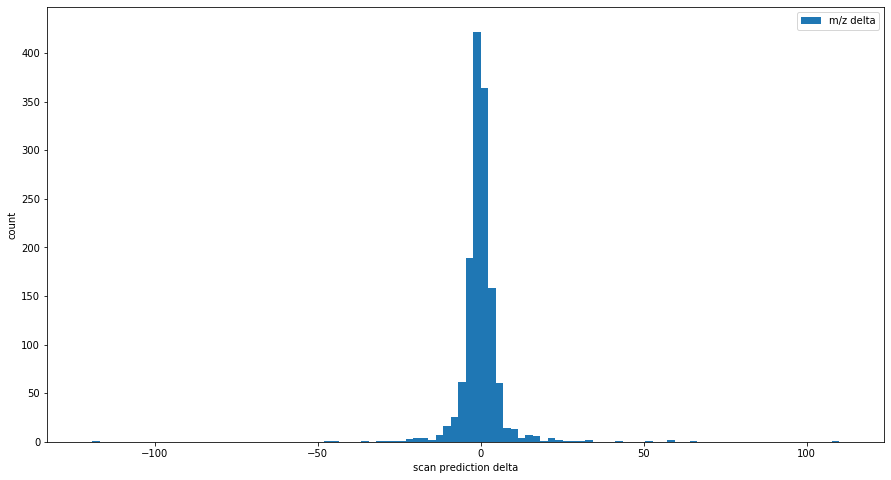

In [57]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(y_test_delta, bins=bins, label='m/z delta')
plt.legend(loc='best')
plt.xlabel('scan prediction delta')
plt.ylabel('count')

plt.show()

RT estimation model (version 1)

In [58]:
merged_df.columns

Index(['file_idx', 'sequence', 'charge', 'run_mz', 'run_scan', 'run_rt',
       'theoretical_mz', 'experiment_scan', 'experiment_rt',
       'experiment_intensity', 'delta_mz', 'delta_scan', 'delta_rt'],
      dtype='object')

In [59]:
X = merged_df[merged_df.file_idx == file_idx][['theoretical_mz','experiment_rt','experiment_scan','experiment_intensity']].values
y = merged_df[merged_df.file_idx == file_idx]['run_rt'].values

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [61]:
# search for the best model in the specified hyperparameter space
param_grid = {'n_estimators':[100], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth':[20, 10, 6, 4], 'min_samples_leaf':[3, 5, 9, 17], 'max_features':[1.0, 0.3, 0.1] }
n_jobs = 4
cv, best_estimator = GradientBooster(param_grid, n_jobs, X_train, y_train)

best estimator found by grid search: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=17, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [62]:
# use the best parameters to train the model
best_estimator.fit(X_train, y_train)
print("R-squared for training set (best model found): {}".format(best_estimator.score(X_train, y_train)))

R-squared for training set (best model found): 0.9996144689173937


In [63]:
# use the trained model to predict the scan for the test set
y_test_predicted = best_estimator.predict(X_test)

In [64]:
y_test_predicted

array([ 684.38152517,  391.44686955,  822.9576861 , ...,  522.12598471,
        860.50153984, 1077.52480338])

In [65]:
y_test

array([ 685.49792264,  397.33      ,  822.78      , ...,  524.96      ,
        861.10117568, 1080.3187248 ])

In [66]:
y_test_delta = np.abs(y_test_predicted) - np.abs(y_test)

In [67]:
np.std(y_test_delta)

11.877132042360303

In [68]:
abs(y_test_delta).max()

396.80480562194776

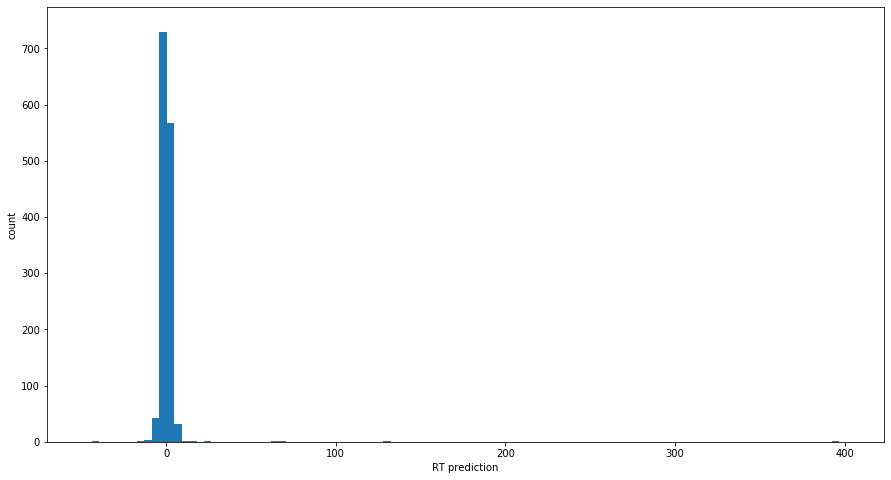

In [71]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(y_test_delta, bins=bins, label='m/z delta')
# plt.legend(loc='best')
plt.xlabel('RT prediction')
plt.ylabel('count')

plt.show()